In [1]:
# Cell 1 – imports
import h5py
import numpy as np
from pprint import pprint


In [2]:
# Cell 2 – open file
file_path = r"D:\Dropbox\Dropbox\To Share\PAUT DATA-yogesh\REPAIR DATA\CRACK\TS003  90_1.nde"  # change to your path
f = h5py.File(file_path, "r")


In [3]:
# Cell 3 – explore tree
def print_tree(h5obj, prefix=""):
    if isinstance(h5obj, h5py.Group):
        for name, item in h5obj.items():
            if isinstance(item, h5py.Group):
                print(f"{prefix}{name}/ (Group)")
                print_tree(item, prefix + "  ")
            else:
                print(f"{prefix}{name} (Dataset) shape={item.shape}, dtype={item.dtype}")

print_tree(f)


Applications/ (Group)
  MXU/ (Group)
    ApplicationInformation (Dataset) shape=(), dtype=|S23
    AscanDescriptor (Dataset) shape=(27,), dtype=|V44
    BusinessSetup (Dataset) shape=(), dtype=|S332466
    CscanDescriptor (Dataset) shape=(81,), dtype=|V44
    DigitalInputColumnDescriptor (Dataset) shape=(1,), dtype=|V12
    EncoderColumnDescriptor (Dataset) shape=(1,), dtype=|V4
    GroupBeamCount (Dataset) shape=(4,), dtype=|V1
    ModelSetup (Dataset) shape=(), dtype=|S88208
    Preview (Dataset) shape=(1,), dtype=|V489
    RawAScan (Dataset) shape=(271, 27, 1), dtype=|V12
    RawCScan (Dataset) shape=(271, 27, 3), dtype=|V24
Domain/ (Group)
  DataGroups/ (Group)
    0/ (Group)
      Datasets/ (Group)
        0/ (Group)
          Amplitude (Dataset) shape=(271, 27, 568), dtype=int16
          Status (Dataset) shape=(271, 27), dtype=uint8
        1/ (Group)
          FiringSource (Dataset) shape=(271, 27), dtype=int16
  Setup (Dataset) shape=(), dtype=|S180962


In [4]:
# Cell 4 – inspect MXU/RawAScan
raw_ascan = f["Applications"]["MXU"]["RawAScan"]
print("RawAScan:", raw_ascan.shape, raw_ascan.dtype)
print("RawAScan attrs:")
pprint(dict(raw_ascan.attrs))


RawAScan: (271, 27, 1) |V12
RawAScan attrs:
{}


In [5]:
# Cell 5 – inspect amplitude & status
amp = f["Domain"]["DataGroups"]["0"]["Datasets"]["0"]["Amplitude"]
status = f["Domain"]["DataGroups"]["0"]["Datasets"]["0"]["Status"]
print("Amplitude:", amp.shape, amp.dtype)
print("Status:", status.shape, status.dtype)
print("Amplitude attrs:")
pprint(dict(amp.attrs))


Amplitude: (271, 27, 568) int16
Status: (271, 27) uint8
Amplitude attrs:
{}


In [6]:
# Cell 6 – firing source mapping
firing = f["Domain"]["DataGroups"]["0"]["Datasets"]["1"]["FiringSource"]
print("FiringSource:", firing.shape, firing.dtype)
print("FiringSource attrs:")
pprint(dict(firing.attrs))


FiringSource: (271, 27) int16
FiringSource attrs:
{}


In [7]:
# Cell 7 – descriptors
ascan_desc = f["Applications"]["MXU"]["AscanDescriptor"]
enc_desc   = f["Applications"]["MXU"]["EncoderColumnDescriptor"]
group_beam = f["Applications"]["MXU"]["GroupBeamCount"]

print("AscanDescriptor attrs:")
pprint(dict(ascan_desc.attrs))
print("EncoderColumnDescriptor attrs:")
pprint(dict(enc_desc.attrs))
print("GroupBeamCount attrs or data:")
try:
    print("GroupBeamCount dataset:", group_beam[()])
except TypeError:
    pprint(dict(group_beam.attrs))


AscanDescriptor attrs:
{}
EncoderColumnDescriptor attrs:
{}
GroupBeamCount attrs or data:


OSError: Can't synchronously read data (no appropriate function for conversion path)

In [8]:
# Cell 8 – guess layout
shape = raw_ascan.shape
print("RawAScan shape:", shape)

if len(shape) == 3:
    n_scan, n_angle, n_sample = shape
    print(f"Interpreting as ascans[scan({n_scan}), angle({n_angle}), sample({n_sample})]")
    ascans = raw_ascan[...]  # already good
elif len(shape) == 2:
    n_shots, n_sample = shape
    print(f"Interpreting as (shots={n_shots}, samples={n_sample}). "
          "We will need FiringSource to map shots -> (scan, angle).")
    # Example: read firing source to see how many beams & positions
    print("FiringSource example element:", firing[0])
else:
    print("Unexpected RawAScan dimensionality, need to inspect manually.")


RawAScan shape: (271, 27, 1)
Interpreting as ascans[scan(271), angle(27), sample(1)]


OSError: Can't synchronously read data (no appropriate function for conversion path)

In [10]:
import h5py
import numpy as np

file_path = r"D:\Dropbox\Dropbox\To Share\PAUT DATA-yogesh\REPAIR DATA\CRACK\TS003  90_1.nde"  # change to your path

f = h5py.File(file_path, "r")

amp_ds = f["Domain"]["DataGroups"]["0"]["Datasets"]["0"]["Amplitude"]
status_ds = f["Domain"]["DataGroups"]["0"]["Datasets"]["0"]["Status"]
firing_ds = f["Domain"]["DataGroups"]["0"]["Datasets"]["1"]["FiringSource"]

ascans_int = amp_ds[...]      # shape (271, 27, 568), int16

print("ascans_int shape:", ascans_int.shape, ascans_int.dtype)


ascans_int shape: (271, 27, 568) int16


In [11]:
# Typical UT amplitudes are stored as signed int16; we can scale to 0–1
ascans = ascans_int.astype(np.float32)
ascans /= np.max(np.abs(ascans)) + 1e-6


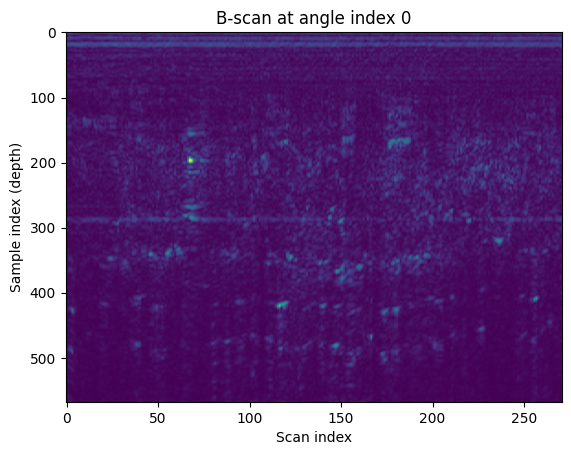

In [12]:
import matplotlib.pyplot as plt

angle_idx = 0  # pick first beam/angle for now
bscan = ascans[:, angle_idx, :]              # (n_scans, n_samples)

# For display, convert to 0–255 uint8
bscan_disp = np.abs(bscan)
bscan_disp /= bscan_disp.max() + 1e-6
bscan_disp = (255 * bscan_disp).astype(np.uint8)

plt.imshow(bscan_disp.T, aspect="auto", origin="upper")
plt.xlabel("Scan index")
plt.ylabel("Sample index (depth)")
plt.title(f"B-scan at angle index {angle_idx}")
plt.show()


In [13]:
biz_raw = f["Applications"]["MXU"]["BusinessSetup"][()]
model_raw = f["Applications"]["MXU"]["ModelSetup"][()]
domain_setup_raw = f["Domain"]["Setup"][()]

print(type(biz_raw), len(biz_raw))
print("First 400 bytes of BusinessSetup:")
print(biz_raw[:400].decode(errors="replace"))


<class 'numpy.bytes_'> 332466
First 400 bytes of BusinessSetup:
<?xml version="1.0" encoding="utf-8"?>
<BusinessSetup xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
  <Version>
    <Major>1</Major>
    <Minor>0</Minor>
    <Type>R</Type>
    <Build>48</Build>
  </Version>
  <DeviceSetups>
    <DeviceSetup>
      <ConventionalTechnology>
        <ProbeAssemblies />
        <PulserVoltage>85</Pulse


Amplitude shape: (271, 27, 568)


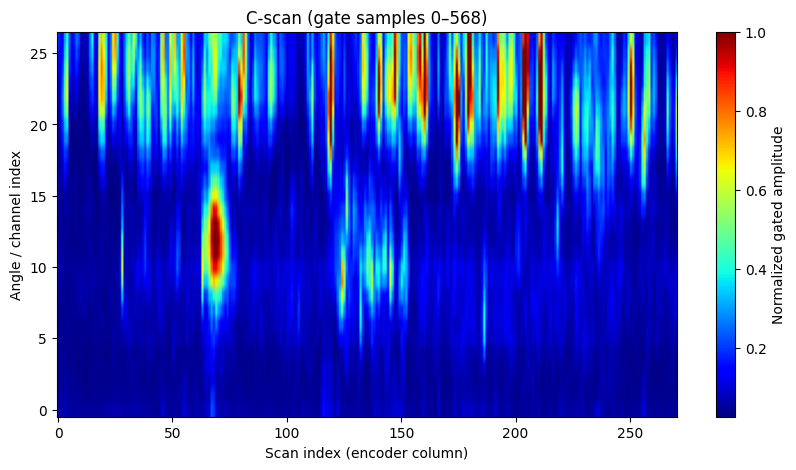

In [15]:
import numpy as np
import matplotlib.pyplot as plt

amp = f["Domain"]["DataGroups"]["0"]["Datasets"]["0"]["Amplitude"][...]
print("Amplitude shape:", amp.shape)  # (271, 27, 568)

amp_abs = np.abs(amp).astype(np.float32)

n_scan, n_angle, n_sample = amp_abs.shape

# ---- choose a depth gate in samples ----
gate_start = 0          # e.g. from sample 0
gate_end   = n_sample   # to the last sample (use full depth for now)
gate_slice = slice(gate_start, gate_end)

# ---- max amplitude within gate → C-scan ----
cscan = amp_abs[:, :, gate_slice].max(axis=2)   # shape (271, 27)

# normalize for display
cscan_norm = cscan / (cscan.max() + 1e-6)

plt.figure(figsize=(10, 5))
plt.imshow(cscan_norm.T, aspect="auto", origin="lower", cmap="jet")
plt.colorbar(label="Normalized gated amplitude")

plt.xlabel("Scan index (encoder column)")
plt.ylabel("Angle / channel index")
plt.title(f"C-scan (gate samples {gate_start}–{gate_end})")
plt.show()
